In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import env

# DBSCAN import
from sklearn.cluster import DBSCAN
# Scaler import
from sklearn.preprocessing import MinMaxScaler

### 1. Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.

In [16]:
query = '''
        SELECT *
        FROM grocery_customers
'''

In [17]:
df = pd.read_sql(query, env.conn('grocery_db'))

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   customer_id       440 non-null    int64
 1   Channel           440 non-null    int64
 2   Region            440 non-null    int64
 3   Fresh             440 non-null    int64
 4   Milk              440 non-null    int64
 5   Grocery           440 non-null    int64
 6   Frozen            440 non-null    int64
 7   Detergents_Paper  440 non-null    int64
 8   Delicassen        440 non-null    int64
dtypes: int64(9)
memory usage: 31.1 KB


In [19]:
df.columns = df.columns.str.lower()

In [20]:
df.head()

,customer_id,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


In [21]:
df['total'] = df.fresh + df.milk + df.grocery + df.frozen + df.detergents_paper + df.delicassen

In [22]:
df.total.sort_values(ascending = False)

85     199891
47     192714
181    190169
183    185683
61     165881
        ...  
131      3730
355      3485
98       2476
97       2158
154       904
Name: total, Length: 440, dtype: int64

In [23]:
# df = df.drop(columns = 'customer_id')

In [24]:
df.head()

,customer_id,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen,total
0,0,2,3,12669,9656,7561,214,2674,1338,34112
1,1,2,3,7057,9810,9568,1762,3293,1776,33266
2,2,2,3,6353,8808,7684,2405,3516,7844,36610
3,3,1,3,13265,1196,4221,6404,507,1788,27381
4,4,2,3,22615,5410,7198,3915,1777,5185,46100


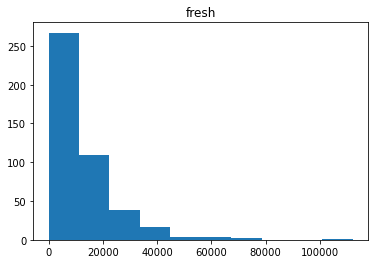

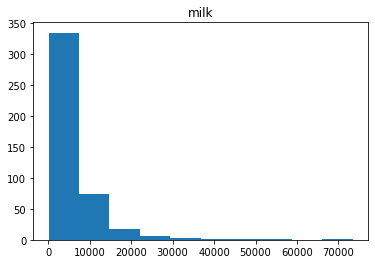

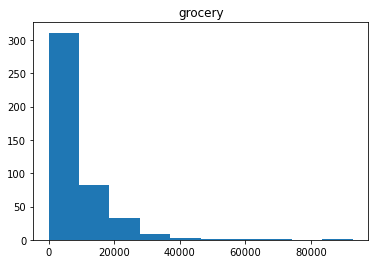

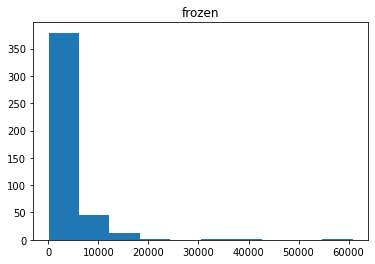

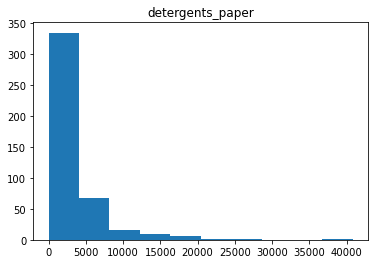

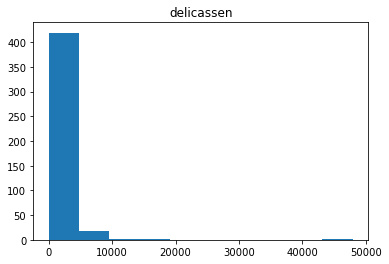

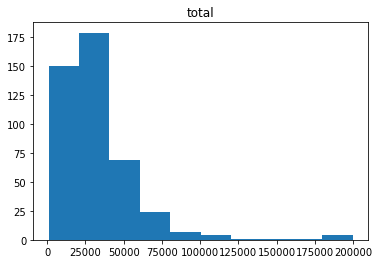

In [25]:
cols = ['fresh', 'milk', 'grocery', 'frozen', 'detergents_paper', 'delicassen', 'total']
for col in cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [26]:
scaler = MinMaxScaler().fit(df[cols])
scaled_df = scaler.transform(df[cols])
scaled_df

array([[0.11294004, 0.13072723, 0.08146416, ..., 0.0654272 , 0.02784731,
        0.16688527],
       [0.06289903, 0.13282409, 0.10309667, ..., 0.08058985, 0.03698373,
        0.16263374],
       [0.05662161, 0.11918086, 0.08278992, ..., 0.08605232, 0.16355861,
        0.17943886],
       ...,
       [0.1295431 , 0.21013575, 0.32594285, ..., 0.36346267, 0.03888194,
        0.3844623 ],
       [0.091727  , 0.02622442, 0.02402535, ..., 0.00404174, 0.04426366,
        0.08508093],
       [0.02482434, 0.02237109, 0.02702178, ..., 0.01161082, 0.00102211,
        0.03359516]])

In [27]:
s_cols = [col + '_scaled' for col in cols]
s_cols

['fresh_scaled',
 'milk_scaled',
 'grocery_scaled',
 'frozen_scaled',
 'detergents_paper_scaled',
 'delicassen_scaled',
 'total_scaled']

In [28]:
scaled_df = pd.DataFrame(scaled_df, columns=s_cols, index=df.index)

In [29]:
scaled_df['customer_id'] = df.customer_id

In [30]:
scaled_df

,fresh_scaled,milk_scaled,grocery_scaled,frozen_scaled,detergents_paper_scaled,delicassen_scaled,total_scaled,customer_id
0,0.112940,0.130727,0.081464,0.003106,0.065427,0.027847,0.166885,0
1,0.062899,0.132824,0.103097,0.028548,0.080590,0.036984,0.162634,1
2,0.056622,0.119181,0.082790,0.039116,0.086052,0.163559,0.179439,2
3,0.118254,0.015536,0.045464,0.104842,0.012346,0.037234,0.133059,3
4,0.201626,0.072914,0.077552,0.063934,0.043455,0.108093,0.227130,4
...,...,...,...,...,...,...,...,...
435,0.264829,0.163338,0.172715,0.215469,0.004385,0.045912,0.363833,435
436,0.349761,0.018736,0.008202,0.073713,0.002205,0.048874,0.238548,436
437,0.129543,0.210136,0.325943,0.006771,0.363463,0.038882,0.384462,437
438,0.091727,0.026224,0.024025,0.016649,0.004042,0.044264,0.085081,438


In [31]:
dbse = DBSCAN(eps=.1, min_samples=20).fit(scaled_df)

In [32]:
df = df.merge(scaled_df, on=df.customer_id).drop(columns='key_0')

In [33]:
df['labels'] = dbse.labels_

In [34]:
df[df.labels == -1]

,customer_id_x,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen,total,fresh_scaled,milk_scaled,grocery_scaled,frozen_scaled,detergents_paper_scaled,delicassen_scaled,total_scaled,customer_id_y,labels
0,0,2,3,12669,9656,7561,214,2674,1338,34112,0.112940,0.130727,0.081464,0.003106,0.065427,0.027847,0.166885,0,-1
1,1,2,3,7057,9810,9568,1762,3293,1776,33266,0.062899,0.132824,0.103097,0.028548,0.080590,0.036984,0.162634,1,-1
2,2,2,3,6353,8808,7684,2405,3516,7844,36610,0.056622,0.119181,0.082790,0.039116,0.086052,0.163559,0.179439,2,-1
3,3,1,3,13265,1196,4221,6404,507,1788,27381,0.118254,0.015536,0.045464,0.104842,0.012346,0.037234,0.133059,3,-1
4,4,2,3,22615,5410,7198,3915,1777,5185,46100,0.201626,0.072914,0.077552,0.063934,0.043455,0.108093,0.227130,4,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,435,1,3,29703,12051,16027,13135,182,2204,73302,0.264829,0.163338,0.172715,0.215469,0.004385,0.045912,0.363833,435,-1
436,436,1,3,39228,1431,764,4510,93,2346,48372,0.349761,0.018736,0.008202,0.073713,0.002205,0.048874,0.238548,436,-1
437,437,2,3,14531,15488,30243,437,14841,1867,77407,0.129543,0.210136,0.325943,0.006771,0.363463,0.038882,0.384462,437,-1
438,438,1,3,10290,1981,2232,1038,168,2125,17834,0.091727,0.026224,0.024025,0.016649,0.004042,0.044264,0.085081,438,-1


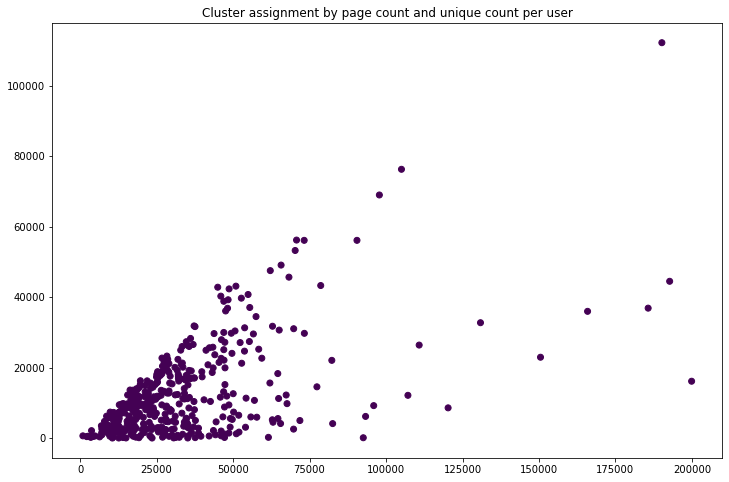

In [35]:
plt.figure(figsize=(12,8))
plt.scatter(df['total'], df['fresh'], c=df['labels'])
plt.title('Cluster assignment by page count and unique count per user')
plt.show()

### 2. Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [36]:
logs = pd.read_table("curriculum-access.txt", sep = '\s', header = None, 
                   names = ['date', 'time', 'page', 'id', 'cohort', 'ip'])

/var/folders/tg/htdzmdmj40vgs24scqz284xm0000gn/T/ipykernel_25331/3925225685.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  logs = pd.read_table("curriculum-access.txt", sep = '\s', header = None,


In [37]:
logs.head()

,date,time,page,id,cohort,ip
0,2018-01-26,09:55:03,/,1,8.0,98.106.20.62
1,2018-01-26,09:56:02,java-ii,1,8.0,98.106.20.62
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,98.106.20.62
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,98.106.20.62
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,98.106.20.62


In [38]:
logs['date'] = pd.to_datetime(logs['date'])

In [39]:
# logs = logs.set_index('date', drop=True)

In [40]:
logs.groupby(['id', 'date'])['page'].count()[logs.groupby(['id', 'date'])['page'].count() > 190]

id   date      
138  2018-06-02    198
313  2018-12-19    225
341  2019-03-03    272
422  2019-07-25    253
526  2019-12-19    192
570  2020-04-05    232
     2020-04-16    271
     2020-04-26    234
Name: page, dtype: int64

In [41]:
logs.groupby('id').page.count().sort_values(ascending=False).head(10)

id
11     11065
64     10784
53      9534
1       5437
344     5370
314     4695
570     3403
423     3281
211     3256
315     2998
Name: page, dtype: int64

### 3. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [2]:
df = pd.read_csv('zillow.csv').iloc[:,1:]

In [3]:
import zillow_wrangle

In [4]:
df = zillow_wrangle.prepare_zillow(df)

In [5]:
df = df[['beds', 'area']]
df

,beds,area
0,4.0,3100.0
1,2.0,1465.0
2,3.0,1243.0
3,4.0,2376.0
4,4.0,2962.0
...,...,...
52436,4.0,2440.0
52437,2.0,1286.0
52438,3.0,1032.0
52439,4.0,1612.0


In [6]:
scaler = MinMaxScaler().fit(df)
scaled_df = scaler.transform(df)

In [7]:
s_cols = [col + '_scaled' for col in df.columns]
s_cols

['beds_scaled', 'area_scaled']

In [8]:
scaled_df = pd.DataFrame(scaled_df, columns=s_cols, index=df.index)

In [9]:
dbsc = DBSCAN(eps=.1, min_samples=20).fit(scaled_df)

In [10]:
dbsc.labels_.shape

(50698,)

In [11]:
scaled_df.shape

(50698, 2)

In [12]:
df = df.merge(scaled_df, on=df.index).drop(columns='key_0')

In [13]:
df['labels'] = dbsc.labels_

In [14]:
df[df.labels == -1]

,beds,area,beds_scaled,area_scaled,labels
672,0.0,5782.0,0.000000,0.259346,-1
2271,9.0,9918.0,0.818182,0.449062,-1
2537,4.0,12039.0,0.363636,0.546351,-1
3291,8.0,11703.0,0.727273,0.530939,-1
4786,8.0,21929.0,0.727273,1.000000,-1
7387,9.0,7970.0,0.818182,0.359708,-1
12800,8.0,11649.0,0.727273,0.528462,-1
15843,7.0,20612.0,0.636364,0.939590,-1
21078,11.0,4012.0,1.000000,0.178157,-1
25841,9.0,8932.0,0.818182,0.403835,-1


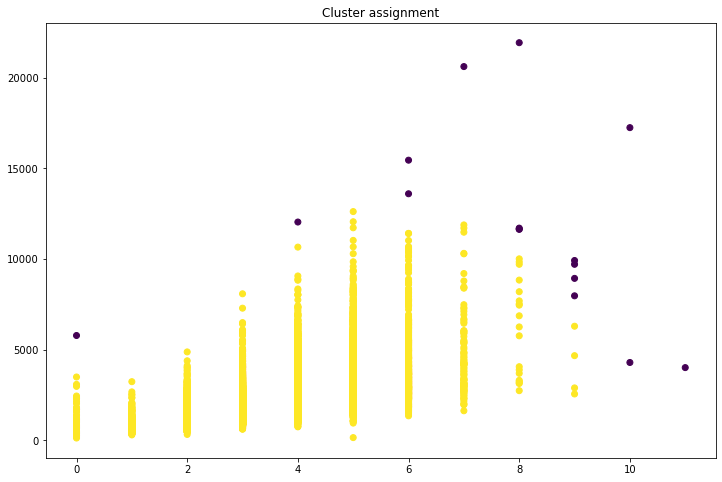

In [15]:
plt.figure(figsize=(12,8))
plt.scatter(df['beds'], df['area'], c=df['labels'])
plt.title('Cluster assignment')
plt.show()